# Capstone Project - The Battle of Neighborhoods

#### Introduction

Japan's parliament has approved a controversial new law allowing hundreds of thousands of foreigners into the country to ease labour shortages.
From April 2019 onwards, foreigners have been allowed to take up jobs in sectors such construction, farming and nursing.
Japan has traditionally been wary of immigration but the government says more foreigners are needed because of Japan's ageing population.Under the new system, more than 300,000 foreigners could be allowed to work in sectors facing a labour crunch.
Japan has a rich cultural heritage when it comes to art, technology and also food. Let us analyse the data to find out about the Ramen restaurants in Japan, Ramen being a very popular food item amongst Japanese as well as non-Japanese people.


#### Data
Picked up list of cities in Japan from  - https://en.wikipedia.org/wiki/List_of_cities_in_Japan

Picked up the Geospatial data of the top 3 populated cities from - https://www.latlong.net/category/cities-111-15.html


#### Steps to follow

1. Picked up data from wikipedia to get the list of cities in Japan
2. Picked the data for longitude and latitude for the 3 most populated cities in Japan
3. Using Foursquare, identified the venues in these 3 cities
4. Explored these venues and their ratings, tips and likes

#### Observations

# Fetch List of Cities in Japan

In [21]:
import pandas as pd

In [22]:
import urllib.request

url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Japan'
req = urllib.request.urlopen(url)
article = req.read().decode()

with open('List_of_cities_in_Japan.html', 'w') as fo:
    fo.write(article)

In [23]:
from bs4 import BeautifulSoup

article = open('List_of_cities_in_Japan.html').read()
soup = BeautifulSoup(article, 'html.parser')
tables = soup.find_all('table', class_='sortable')

for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[:8] == ['City (Special Ward)', 'Japanese', 'Prefecture', 'Population','Area','Density','Founded','Homepage']:
        break

with open('cities_in_japan.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if not tds:
            continue
        col1, col2, col3, col4, col5, col6, col7, col8 = [td.text.strip() for td in tds[:8]]        
        
        print(';'.join([col1, col2, col3, col4, col5, col6, col7, col8]), file=fo)
        
data = pd.read_csv('cities_in_japan.txt', sep=";",header=None)
data.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8']
data = data.drop(columns=['col2','col6','col7','col8'])
data.columns=['City','Prefecture','Population','Area']         
data.head(3)



,City,Prefecture,Population,Area
0,Nagoya,Aichi,"2,283,289",326.45
1,Toyohashi,Aichi,"377,045",261.35
2,Okazaki,Aichi,"371,380",387.24


In [24]:
data = data.apply(lambda x: x.str.replace(',',''))
data.dtypes

City          object
Prefecture    object
Population    object
Area          object
dtype: object

In [25]:
data = data.astype({"Population": int, "Area": float})

In [37]:
data = data.sort_values(by='Population', ascending=False)
dataset = data.head(3)
dataset



,City,Prefecture,Population,Area
730,Tokyo Ward AASpecial wards of Tokyo,Tokyo,8637098,621.81
355,Yokohama,Kanagawa,3697894,437.38
555,Osaka,Osaka,2668586,222.30


In [39]:
dataset.insert(4, "Latitude", [35.652832, 35.443707, 34.669529], True) 


In [41]:
dataset.insert(5,"Longitude", [139.839478,139.638031,135.497009], True)

In [42]:
dataset

,City,Prefecture,Population,Area,Latitude,Longitude
730,Tokyo Ward AASpecial wards of Tokyo,Tokyo,8637098,621.81,35.652832,139.839478
355,Yokohama,Kanagawa,3697894,437.38,35.443707,139.638031
555,Osaka,Osaka,2668586,222.30,34.669529,135.497009


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [58]:
CLIENT_ID = 'YBT4LLDV1IP0XRTAUK1BD5OZY4GBHWXTDOKMQFCT0I2YR3XB' # your Foursquare ID
CLIENT_SECRET = 'G1QSFA0ECSZYGSHNAATC3Z25ZNRDKGA0DF0ZL1CBHPUABOPC' # your Foursquare Secret
VERSION = '20190809' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
RADIUS=1200
LIMIT=100

Your credentails:
CLIENT_ID: YBT4LLDV1IP0XRTAUK1BD5OZY4GBHWXTDOKMQFCT0I2YR3XB
CLIENT_SECRET:G1QSFA0ECSZYGSHNAATC3Z25ZNRDKGA0DF0ZL1CBHPUABOPC


In [59]:
def fetch_venues(lat,long):   
   
    #url to explore venues
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long, 
            RADIUS, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [97]:
def fetch_venue_details(venue_id):
        
   
    #fetch venues url
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df    

In [89]:
column_names=['Prefecture', 'City', 'ID','Name']
resto_list=pd.DataFrame(columns=column_names)

for row in dataset.values.tolist():
    city, pref, pop, area, Latitude, Longitude=row
    venues = fetch_venues(Latitude,Longitude)
    restaurants=venues[venues['Category']=='Ramen Restaurant']   
    print(len(restaurants),'Ramen Restaurant(s) in '+city)
    for restaurant in restaurants.values.tolist():
        id, name , category=restaurant
        resto_list = resto_list.append({'Prefecture': pref,
                                                'City': city, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    
    
resto_list

0 Ramen Restaurant(s) in Tokyo Ward AASpecial wards of Tokyo
7 Ramen Restaurant(s) in Yokohama
4 Ramen Restaurant(s) in Osaka


,Prefecture,City,ID,Name
0,Kanagawa,Yokohama,4b7cd69af964a52010a72fe3,Tenkaippin (天下一品)
1,Kanagawa,Yokohama,4b6d3c91f964a520e66c2ce3,Yousyu-Syonin (揚州商人)
2,Kanagawa,Yokohama,4b496456f964a520f16e26e3,Ramen Jiro (ラーメン二郎 横浜関内店)
3,Kanagawa,Yokohama,58e709d73ef0f614ce44072d,中華蕎麦 時雨
4,Kanagawa,Yokohama,51b12755abd89a0e082663f7,Hechikan (丿貫)
5,Kanagawa,Yokohama,5438108a498e00613171318a,Hoshino Chukasoba Ramen (地球の中華そば)
6,Kanagawa,Yokohama,4d0c3326bdbfa35d75506272,北海道ラーメン来々軒 本店
7,Osaka,Osaka,4c2d50a8987f20a12d5749aa,つけ麺 雀
8,Osaka,Osaka,4b6186bbf964a520d9162ae3,Ichiran (一蘭 道頓堀店本館)
9,Osaka,Osaka,552fca5e498e14c3cc433e6f,Ichiran (一蘭 道頓堀店別館)


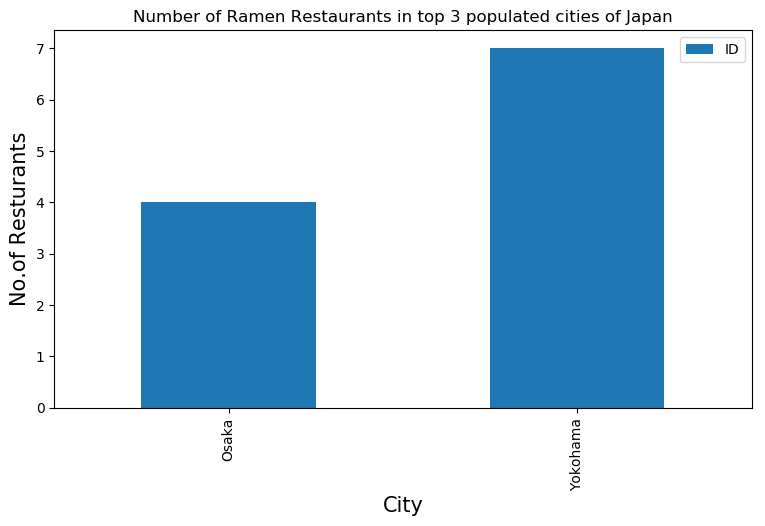

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Ramen Restaurants in top 3 populated cities of Japan')
#On x-axis
plt.xlabel('City', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
resto_list.groupby('City')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [98]:

column_names=['Prefecture', 'City', 'ID','Name','Likes','Rating','Tips']
resto_stats=pd.DataFrame(columns=column_names)



for row in resto_list.values.tolist():
    pref,city,ID,Name=row
    try:
        venue_info=fetch_venue_details(ID)
        venue_info
        id,name,likes,rating,tips=venue_info.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)       
        id,name,likes,rating,tips=[0]*5
    
    resto_stats = resto_stats.append({'Prefecture': pref,
                                                'City': city, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
resto_stats.head()

,Prefecture,City,ID,Name,Likes,Rating,Tips
0,Kanagawa,Yokohama,4b7cd69af964a52010a72fe3,Tenkaippin (天下一品),61,8.1,14
1,Kanagawa,Yokohama,4b6d3c91f964a520e66c2ce3,Yousyu-Syonin (揚州商人),51,8.5,11
2,Kanagawa,Yokohama,4b496456f964a520f16e26e3,Ramen Jiro (ラーメン二郎 横浜関内店),200,9.0,35
3,Kanagawa,Yokohama,58e709d73ef0f614ce44072d,中華蕎麦 時雨,14,7.8,5
4,Kanagawa,Yokohama,51b12755abd89a0e082663f7,Hechikan (丿貫),35,8.5,16


In [99]:
resto_stats.dtypes

Prefecture     object
City           object
ID             object
Name           object
Likes          object
Rating        float64
Tips           object
dtype: object

In [100]:
#convert likes and tips to int
resto_stats['Tips']=resto_stats['Tips'].astype('float64')
resto_stats['Likes']=resto_stats['Likes'].astype('float64')

In [101]:
#Restaurant with max likes
resto_stats.iloc[resto_stats['Likes'].idxmax()]

Prefecture                       Osaka
City                             Osaka
ID            552fca5e498e14c3cc433e6f
Name               Ichiran (一蘭 道頓堀店別館)
Likes                              326
Rating                             8.6
Tips                                86
Name: 9, dtype: object

In [102]:
#Restaurant with highest rating
resto_stats.iloc[resto_stats['Rating'].idxmax()]

Prefecture                     Kanagawa
City                           Yokohama
ID             4b496456f964a520f16e26e3
Name          Ramen Jiro (ラーメン二郎 横浜関内店)
Likes                               200
Rating                                9
Tips                                 35
Name: 2, dtype: object